In [45]:
import ast
import re
import pandas as pd
import matplotlib.pyplot as plt

In [46]:
#df = pd.read_csv("../data/model_data.csv")
df = pd.read_csv("../data/police_press_releases_full_enriched.csv")
# Parse list-like string columns safely (your CSV stores lists as strings like "['Grievous']")
def parse_list_cell(x):
    if pd.isna(x):
        return []
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        s = x.strip()
        if s == "[]":
            return []
        try:
            val = ast.literal_eval(s)
            return val if isinstance(val, list) else [val]
        except Exception:
            return [s]
    return [x]

def parse_vehicle_list(x):
    if pd.isna(x):
        return []
    try:
        return ast.literal_eval(x)
    except Exception:
        return []

if "injuries" in df.columns:
    df["injuries_list"] = df["injuries"].apply(parse_list_cell)
else:
    df["injuries_list"] = [[]] * len(df)

# Dates / time
df["date_published"] = pd.to_datetime(df["date_published"], errors="coerce")

# Extract hour from "time" like "09:30"
def hour_from_time(t):
    if pd.isna(t):
        return pd.NA
    m = re.match(r"^\s*(\d{1,2})", str(t))
    return int(m.group(1)) if m else pd.NA

df["hour"] = df["time"].apply(hour_from_time)

# Month name for nicer plots
df["month"] = df["date_published"].dt.to_period("M").dt.to_timestamp()
df["month_name"] = df["date_published"].dt.strftime("%b")
df["month_num"] = df["date_published"].dt.month


Accidents per day of week

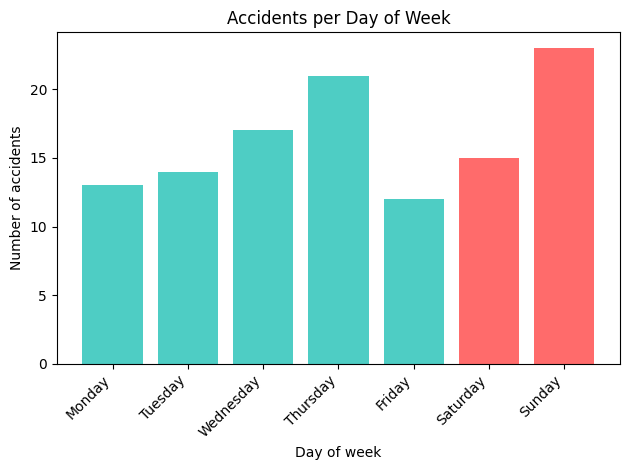

In [47]:
if "day" in df.columns:
    dow_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    accidents_by_dow = df["day"].value_counts().reindex(dow_order).fillna(0)

    day_counts = df['day'].value_counts().reindex(dow_order)
    colors = ['#ff6b6b' if d in ['Saturday', 'Sunday'] else '#4ecdc4' for d in dow_order]
    colors = ['#ff6b6b' if d in ['Saturday', 'Sunday'] else '#4ecdc4' for d in dow_order]

    plt.figure()
    plt.bar(accidents_by_dow.index, accidents_by_dow.values, color=colors)
    plt.title("Accidents per Day of Week")
    plt.xlabel("Day of week")
    plt.ylabel("Number of accidents")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()



Accidents per hour

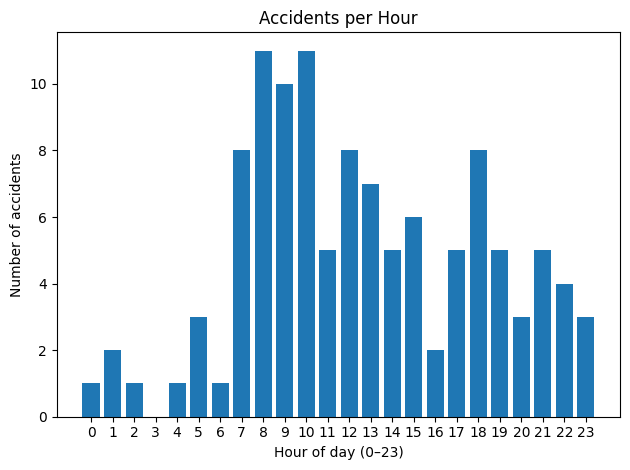

In [48]:

accidents_by_hour = df["hour"].dropna().astype(int).value_counts().sort_index()
# Ensure full 0-23 axis exists
accidents_by_hour = accidents_by_hour.reindex(range(24)).fillna(0)

plt.figure()
plt.bar(accidents_by_hour.index, accidents_by_hour.values)
plt.title("Accidents per Hour")
plt.xlabel("Hour of day (0–23)")
plt.ylabel("Number of accidents")
plt.xticks(range(0, 24, 1), rotation=0)
plt.tight_layout()
plt.show()



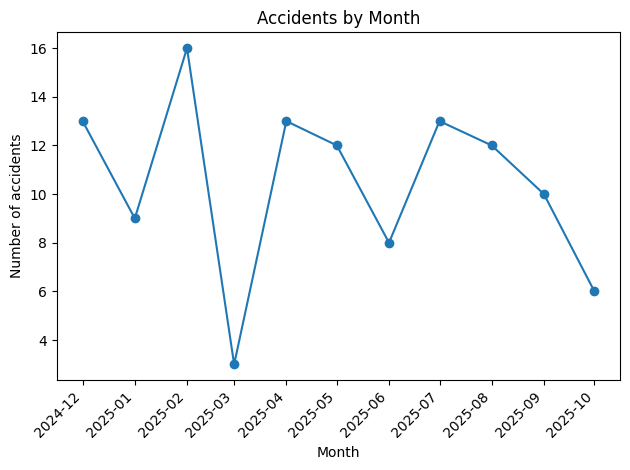

In [49]:
monthly_counts = df.dropna(subset=["date_published"]).groupby("month").size().sort_index()

plt.figure()
plt.plot(monthly_counts.index, monthly_counts.values, marker="o")
plt.title("Accidents by Month")
plt.xlabel("Month")
plt.ylabel("Number of accidents")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Age distribution of drivers (age)

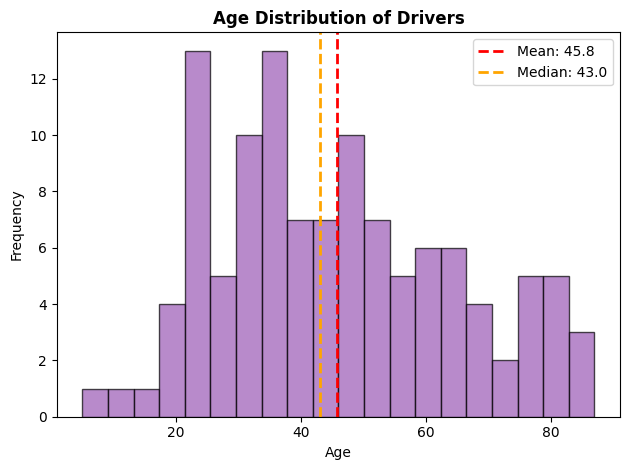

In [50]:
if "age" in df.columns:
    age_data = pd.to_numeric(df["age"], errors="coerce").dropna()
    plt.hist(age_data, bins=20, color='#9b59b6', edgecolor='black', alpha=0.7)

    plt.axvline(age_data.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {age_data.mean():.1f}')
    plt.axvline(age_data.median(), color='orange', linestyle='--', linewidth=2,
                label=f'Median: {age_data.median():.1f}')

    plt.title('Age Distribution of Drivers', fontweight='bold')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.legend()

    plt.tight_layout()
    plt.show()

Injury severity distribution

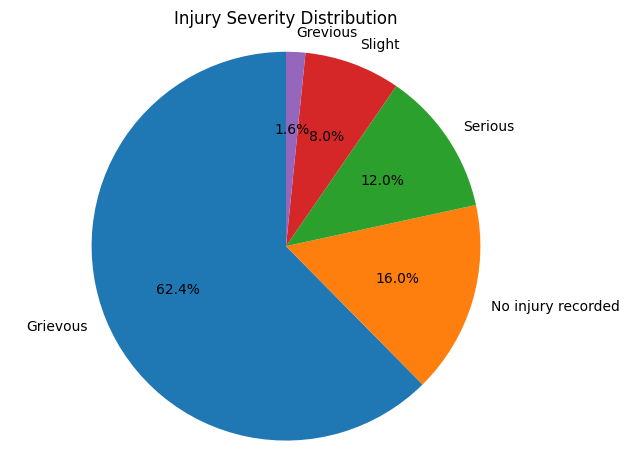

In [51]:
inj_exploded = df[["injuries_list"]].explode("injuries_list")
inj_exploded["injury_severity"] = inj_exploded["injuries_list"].replace("", pd.NA)
inj_exploded["injury_severity"] = inj_exploded["injury_severity"].fillna("No injury recorded")

injury_counts = inj_exploded["injury_severity"].value_counts()

plt.figure()
plt.pie(
    injury_counts.values,
    labels=injury_counts.index,
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Injury Severity Distribution")
plt.axis("equal")  # keeps it circular
plt.tight_layout()
plt.show()


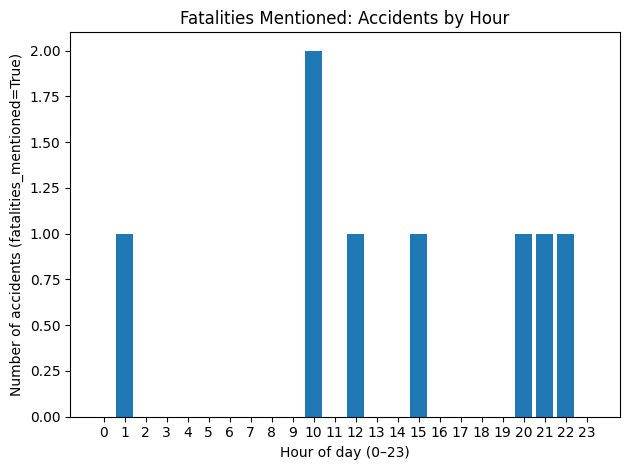

In [52]:
if "fatalities_mentioned" in df.columns:
    fatal_df = df[df["fatalities_mentioned"] == True].copy()
    fatal_by_hour = fatal_df["hour"].dropna().astype(int).value_counts().sort_index()
    fatal_by_hour = fatal_by_hour.reindex(range(24)).fillna(0)

    plt.figure()
    plt.bar(fatal_by_hour.index, fatal_by_hour.values)
    plt.title("Fatalities Mentioned: Accidents by Hour")
    plt.xlabel("Hour of day (0–23)")
    plt.ylabel("Number of accidents (fatalities_mentioned=True)")
    plt.xticks(range(0, 24, 1))
    plt.tight_layout()
    plt.show()


Proportion of Vehicles

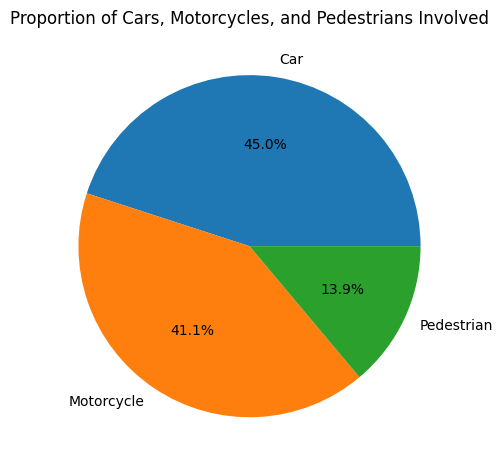

In [53]:
df["vehicles_list"] = df["vehicles"].apply(parse_vehicle_list)

# --- Explode to one vehicle per row ---
vehicles_exploded = df[["vehicles_list"]].explode("vehicles_list")

# Normalize names (optional but recommended)
vehicles_exploded["vehicle"] = vehicles_exploded["vehicles_list"].str.lower()

vehicles_exploded["vehicle"] = vehicles_exploded["vehicle"].replace({
    "car": "Car",
    "cars": "Car",
    "motorcycle": "Motorcycle",
    "motorbike": "Motorcycle",
    "scooter": "Motorcycle",
    "pedestrian": "Pedestrian",
    "pedestrians": "Pedestrian"
})

# Keep only what we care about
vehicles_exploded = vehicles_exploded[
    vehicles_exploded["vehicle"].isin(["Car", "Motorcycle", "Pedestrian"])
]

# --- Count + plot ---
vehicle_counts = vehicles_exploded["vehicle"].value_counts()

plt.figure()
plt.pie(
    vehicle_counts.values,
    labels=vehicle_counts.index,
    autopct="%1.1f%%"
)
plt.title("Proportion of Cars, Motorcycles, and Pedestrians Involved")
plt.tight_layout()
plt.show()

Correlation (visibility vs accidents): 0.9902924154744338


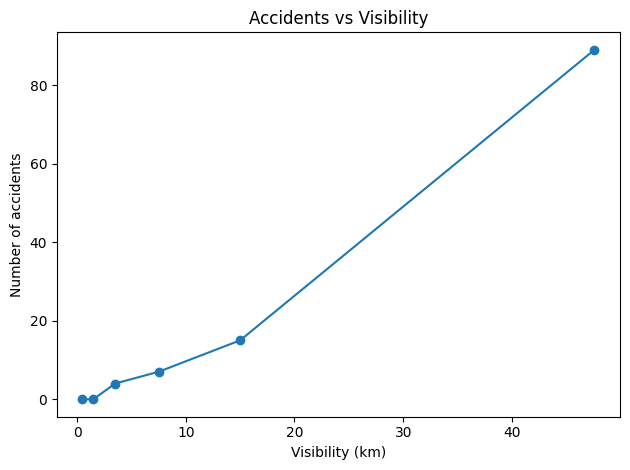

In [54]:
df["hourly_visibility_km"] = df["hourly_visibility"]/1000
df["hourly_visibility_km"] = pd.to_numeric(df["hourly_visibility_km"], errors="coerce")

# Drop missing
vis_df = df.dropna(subset=["hourly_visibility_km"])

# Bin visibility (km)
vis_df["visibility_bin"] = pd.cut(
    vis_df["hourly_visibility_km"],
    bins=[0, 1, 2, 5, 10, 20, vis_df["hourly_visibility_km"].max()],
    include_lowest=True
)

accidents_by_visibility = vis_df["visibility_bin"].value_counts().sort_index()

# Correlation (bin midpoint vs count)
bin_midpoints = accidents_by_visibility.index.map(lambda x: x.mid)
x = pd.Series(bin_midpoints.astype(float))
y = pd.Series(accidents_by_visibility.values.astype(float))
correlation_visibility = x.corr(y)

print("Correlation (visibility vs accidents):", correlation_visibility)

plt.figure()
plt.plot(bin_midpoints, accidents_by_visibility.values, marker="o")
plt.title("Accidents vs Visibility")
plt.xlabel("Visibility (km)")
plt.ylabel("Number of accidents")
plt.tight_layout()
plt.show()

In [55]:
df.to_csv("../data/final_data.csv", index=False)